# Recommender Systems  Matrix Factorization 
# Introduction
In this task, we implemented a Recommender Model based on **Matrix Factorization** algorithm. This model is used to recommend movies to users based on historical ratings data. In next sections we will discuss the dataset we used, approaches of Data Exploration, Data Preprocessing, Implementation and Optimization of the Model, and Experiments and Results.  

In [2]:
import numpy as np
import pandas as pd
import math
import random
import sys
from sklearn.model_selection import KFold

from math import sqrt

#Import libs to plot the training process
import matplotlib
import matplotlib.pyplot as plt

# Data
The data set we used in this experiment is the MovieLens 1M dataset. There are 5 files in the dataset and we only use the file ratings.csv. The file ratings.csv contains 100836 ratings created by 610 users about 9742 movies; each line of this file below the header represents one rating of one movie(represented by movieId) by one user(represented by userId) and its timestamp. To make things easier, we only use the 3 columns: userId, movieId and rating. The following figure shows how the data looks like: 

![Original Dataset](./figures/figure1.png)

<center>figure 1: Some Lines of Ratings.csv</center>

# Approaches
Approaches  to implement recommender system in this assignment are listed below.

## Data Exploration
The purpose of Initial Data Analysis is to understand what is in a dataset and the characteristics of the data. We calculated the mean value and plotted the distribution of ratings.

In [3]:
#Reading The Data into DataFrame
#Define the file path
file_path = './ml-latest-small//ratings.csv'#"./ml-latest-small/ratings.csv" 
df_ratings = pd.read_csv(file_path, header=0, names=['userId', 'movieId', 'rating'], index_col=False)

df_ratings.head(5) #Top 5 records in the dataset 

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [4]:
#The average rating in the dataset
df_ratings.rating.mean()

3.501556983616962

The mean of the ratings is about 3.5

The following figure shows the distribution of the ratings.

/Users/zzfang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


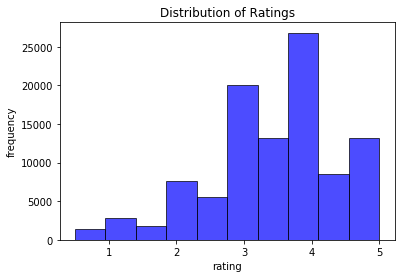

In [14]:
#Show distribution of ratings

data = df_ratings.rating.tolist()

plt.title("Distribution of Ratings")
plt.hist(data, bins=10, normed=0, facecolor="blue", edgecolor='black', alpha=0.7)
plt.xlabel("rating")
plt.ylabel("frequency")

plt.show()

<center>figure 2: Distribution of The Ratings<\center>

In [6]:
#Show huge gap of the numbering 

print("Range of userId: ", "[",df_ratings.userId.min(), ",",df_ratings.userId.max(), "]")
print("Number of userId: ", len(df_ratings.userId.unique()))

print("Range of movieId: ", "[", df_ratings.movieId.min(), ",", df_ratings.movieId.max(), "]")
print("Number of userId: ", len(df_ratings.movieId.unique()))

Range of userId:  [ 1 , 610 ]
Number of userId:  610
Range of movieId:  [ 1 , 193609 ]
Number of userId:  9724


There are are 9724 movies but the movieIds range from 1 to 193609, so there is a huge gap in the numbering of movieIds, which costs huge storage waste and high sparsity in rating matrix.

## Data Preprocessing
The purpose of data preprocessing is to fix the huge gap of the numbering of the original movieId. To reduce the large gap of the numbering, we put the unique movieIds and userIds in lists and use the indices of the lists of new Ids of movies and users. After renumberring the Ids, a rating matrix will be constructed according to the new Ids.

In [7]:
# Renumbering user and movie IDs
uniqueMovieIds = df_ratings.movieId.unique() #Obtain the unique movie Ids
uniqueUserIds = df_ratings.userId.unique() #Obtain the unique user Ids

#Create New movieIds according to unique movie Ids
newMovieIds = [np.where(uniqueMovieIds==x)[0][0] for x in df_ratings['movieId'].tolist()]
newMovieIds = np.array(newMovieIds)

#Create New userIds according to unique user Ids
newUserIds = [np.where(uniqueUserIds==x)[0][0] for x in df_ratings['userId'].tolist()]
newUserIds = np.array(newUserIds)

In [8]:
#Add new movieIds and new userIds to the dataframe
df_ratings['newMovieId'] = newMovieIds
df_ratings['newUserId'] = newUserIds

#Reconstruct the dataframe
df_ratings = df_ratings[["newUserId","newMovieId","rating"]]

In [9]:
#Construct The Rating Matrix acorting to the new ids
num_users = df_ratings['newUserId'].max()+1  #There are 610 users
num_movies = df_ratings['newMovieId'].max()+1 #The Max Value of movieId

ratings = np.zeros((num_users , num_movies))

print(ratings.shape) #Show the shape of the rating matrix

for i in range(df_ratings.shape[0]):
    ratings[df_ratings.loc[i, 'newUserId']][df_ratings.loc[i,'newMovieId']] = df_ratings.loc[i, 'rating']

(610, 9724)


In [10]:
# Calculate the density of the matrix
density = len(np.nonzero(ratings)[0])/(ratings.shape[0]*ratings.shape[1])
print("The density of rating matrix: ", density)

The density of rating matrix:  0.016999683055613623


The density of the rating matrix is about 0.017; it is still very sparse because most users only reviewed few movies compared with the large number of movies.

## Algorithm for Recommandation
We used **Matrix Factorization** for the recommender system. Matrix Factorization is a class of collaborative filtering algorithms. The algorithm attemps to decompose the rating matrix $R$ into the product of 2 lower dimensionality matrices U and M,  in which the users and items are represented in a lower dimensional latent space(K-dimensional Vector).  During the training process, the algorithm will try to minimize the loss function, which is presented by following formula:
<center>$||R_{m,n}- U_{m,k}\times M_{n,k}~T||^2+\lambda (||U_{m, k}||^2 + ||M_{n, k}||^2)$ 
    
In above formula, $||X||^2$ means the sum of squares of items of matrix X:
<center>$||X||^2 = \sum_{x\in X}x^2$
    
**Gradient Descent** and **Alternating Least Square(ALS)** is used to minimize the loss function.

After training the parametres of the K-dimensional vectors of users and movies, the rating of movie m given by user u will be the dot product of the user and movie vectors.

<center>$r_{u,m} = u\cdot m$

## Methods for Processing Missing Ids
During the test of a model, there might be some userIds and movieIds which are present in test set but not present in the training set. Because the parametres of the vectors of these users or movies are not trained before, it is unreliable to use the dot product of their vectors to calculate the ratings.

We considered to check which Ids are missing in the training set after splitting the dataset into training set and test set and add some samples from test set to the training set. It seems that this method worked well but it can cause **Data Leakage**[5]; i.e. **Information from outside the training set is used to create the model, which can cause one to create overly optimistic if not completely invalid predictive models.**

Instead, we will use the mean value for smoothing, i.e. we will treat the mean of all ratings in the training set as the rating of movie m by user u if u or m not present in the dataset.

## Cross Validation and Evaluation 
**5-fold** cross validation[6] is applied in our experiment to monitor the training process; i.e. We splitted the data into 5 non-overlapping parts and developed 5 same models; each model will choose one part as test set and the remaining 4 as training set. Mean Squared Error(mse) is used to evaluate the models. The final results will be the average mse of the 5 models.

The code implementing the Matrix Factorization model is listed below

In [11]:
#MatrixFactorization Model
class MatrixFactorization():
    def __init__( self, R=ratings, df=df_ratings, K=20, lr=0.001, rp=0.01, itr= 3, nfolds=5, method='GD', draw=False, threshold=0): 
        #change itr and set thresholds
        """
        Arguments/Hyperparamters
        -R: user-movie: rating matrix
        -K: number of latent dimensions of user & movie vectors
        -lr: learning rate
        -rp: regularization parametre
        -itr: number of iterations
        -df: dataframe of three columns: user, movie and rating
        -method: GD or ALS
        """     
        self.R=R
        self.df = df
        self.num_users, self.num_movies = R.shape
        self.K = K
        self.lr = lr
        self.rp = rp
        self.itr = itr
        self.nfolds = nfolds
        self.method = method
        self.draw=draw
        self.threshold = threshold
              
    def train_n_times(self):
        # set up the empty result list
        err=[]
        kf = KFold(n_splits= self.nfolds, shuffle=True)
        n_t = 1
        for train_index, test_index in kf.split(self.df):
            print('Training No.', n_t)
            n_t += 1
            training_set, test_set = self.df.iloc[train_index], self.df.iloc[test_index]
            self.check_matrix = np.zeros(self.R.shape)
            training_process = self.train(training_set, test_set)
            err.append(training_process )
        return (err)
            
    def gradient_descent(self, training):
        #Update the parametres of user&movie matrix in one iteration
        for u, m, r in training:
                error = self.R[u][m] - self.predict_um(u,m)
                self.U[u] += self.lr*(error*self.M[m]-self.rp*self.U[u])
                self.M[m] += self.lr*(error*self.U[u] - self.rp*self.M[m])
    
    def ALS(self, training):
        #Update the parametres of user&movie matrix in one iteration
        r_mat= np.zeros((self.num_users , self.num_movies))
        for u, m, r in training:
            r_mat[u][m] = r
        self.U[:,0] = np.mean(r_mat, axis = 1)
        self.M[:,0] = np.mean(r_mat, axis = 0)
        
        for u in range(self.num_users):
            vec = r_mat[u,:].nonzero()[0]
            MI = self.M[vec,:]
            n = max(len(vec),1)
            A = np.dot(MI.T,MI) + self.rp*n*np.eye(self.K)
            V = np.dot(MI.T,r_mat[u,vec])
            self.U[u,:] = np.linalg.solve(A,V)

        for m in range(self.num_movies):
            vec = r_mat[:,m].nonzero()[0]
            UI = self.U[vec,:]
            n = max(len(vec),1)
            A = np.dot(UI.T,UI) + self.rp*n*np.eye(self.K)
            V = np.dot(UI.T,r_mat[vec,m])
            self.M[m,:] = np.linalg.solve(A,V)

    def train(self, training_set, test_set):
        #Initialize user & movie matrices 
        np.random.seed(2019)
        self.U = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        np.random.seed(2019)
        self.M = np.random.normal(scale=1./self.K, size=(self.num_movies, self.K))
        
        #Perform stochastic gradient descent 
        training_process = []
        training = training_set.as_matrix().astype(int)
        test = test_set.as_matrix().astype(int)
        for i in range(self.itr):
            if self.method == 'GD':
                self.gradient_descent(training)
            elif self.method == 'ALS':
                self.ALS(training)
            else:
                sys.exit("Oops! Use GD or ALS as your method")
            mse_training = self.calculate_mse(training)
            mse_test = self.calculate_mse(test, mode="test")
            training_process.append((i, mse_training, mse_test))
        
            print("Iteration: %d; mse_traing: %.4f; mse_test: %.4f"%(i+1, mse_training, mse_test))
            if mse_training <= self.threshold:
                break
        if self.draw==True:
            self.drawplot(training_process)
        return training_process
            
         
    def drawplot(self,training_process):
        iterations = [i for i, mse_training, mse_test in training_process]
        mse_training = [mse_training for i, mse_training, mse_test in training_process]
        mse_test = [mse_test for i, mse_training, mse_test in training_process]
        plt.figure(figsize=(16, 4))
        plt.title("Training Error And Validation Error")
        plt.plot(iterations, mse_training, color='blue', label = 'training error')
        plt.plot(iterations, mse_test, color='orange', label='validation error')
        plt.xticks(iterations, iterations)
        plt.xlabel("Iterations")
        plt.ylabel("Mean Square Error")
        plt.legend()
        plt.grid(axis="y")
        plt.show()
   
    def round_of_rating(self, R):
        R[np.where(R<1)]=1
        R[np.where(R>5)] = 5     
        return R
    
    
    def predictAll(self):
        #Predict All the Ratings, return a full rating matrix
        predictions = self.U.dot(self.M.T)
        return self.round_of_rating(predictions)       
    
    def predict_um(self, u, m, mode="train"):
        #Predict the rating of user u to movie m
        
        if mode=="test":
            if np.count_nonzero(self.check_matrix[u])==0 or np.count_nonzero(self.check_matrix.T[m])==0:
               #userId or movieId not present in training_set                
                   return self.check_matrix.mean()
            return self.U[u,:].dot(self.M[m].T)
            
        
        prediction = self.U[u,:].dot(self.M[m].T)
        self.check_matrix[u][m]=prediction
        return prediction
    
    def calculate_mse(self, d, mode="train"):
        #Calculate mse for Training/Testing set
        #train_pred['diff'] = (d.rating - self.predictALL))**2
        #err_train.append(np.sqrt(train_pred['diff'].mean()))
        num_of_d = len(d)
        error = 0
        
        for i, j, r  in d:
            prediction = self.predict_um(i,j, mode)
            error += (prediction - self.R[i][j] )**2
            
        error = error/num_of_d
        return error

## Usage of The Model
A user can run Matrix Factorization algorithm by instantiating an instant of the above Matrix Factorization class. Through passing different parametres to constructor, the user can choose the number of latent factors, learning rate, regularization parametre, number of iterations and the optimizer(**Gradient Descent**(**GD**) or **Alternating Least Square**(**ALS**)). 

<br>After instantiating the instant, the user can call the train_n_times() method of the object to train the model. The training process will be plotted after each training.
Some examples of running the algorithm are listed below:

In [15]:
#A running example with 4 iterations and Gradient Descent as Optimization Method
#learning_rate = 0.001, regularization_parametre = 0.01, number_of_latent_factors = 20
mf = MatrixFactorization(itr=4)
err = mf.train_n_times() #record the error during the training process

Training No. 1


/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Iteration: 1; mse_traing: 13.3420; mse_test: 13.3608
Iteration: 2; mse_traing: 13.3386; mse_test: 13.3600
Iteration: 3; mse_traing: 13.3334; mse_test: 13.3577
Iteration: 4; mse_traing: 13.3245; mse_test: 13.3517
Training No. 2
Iteration: 1; mse_traing: 13.3463; mse_test: 13.3435
Iteration: 2; mse_traing: 13.3428; mse_test: 13.3427
Iteration: 3; mse_traing: 13.3375; mse_test: 13.3404
Iteration: 4; mse_traing: 13.3282; mse_test: 13.3345
Training No. 3
Iteration: 1; mse_traing: 13.3580; mse_test: 13.2972
Iteration: 2; mse_traing: 13.3545; mse_test: 13.2964
Iteration: 3; mse_traing: 13.3494; mse_test: 13.2940
Iteration: 4; mse_traing: 13.3405; mse_test: 13.2881
Training No. 4
Iteration: 1; mse_traing: 13.3503; mse_test: 13.3279
Iteration: 2; mse_traing: 13.3467; mse_test: 13.3271
Iteration: 3; mse_traing: 13.3415; mse_test: 13.3248
Iteration: 4; mse_traing: 13.3323; mse_test: 13.3188
Training No. 5
Iteration: 1; mse_traing: 13.3299; mse_test: 13.4096
Iteration: 2; mse_traing: 13.3265; mse_

In [16]:
#A running example with 4 iterations and ALS as Optimization Method
#learning_rate = 0.001, regularization_parametre = 0.01, number_of_latent_factors = 20
mf = MatrixFactorization(itr=4, method='ALS')
err = mf.train_n_times() #record the error during the training process

Training No. 1


/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Iteration: 1; mse_traing: 0.4335; mse_test: 2.8988
Iteration: 2; mse_traing: 0.3663; mse_test: 3.0507
Iteration: 3; mse_traing: 0.3279; mse_test: 2.8568
Iteration: 4; mse_traing: 0.2935; mse_test: 2.4415
Training No. 2
Iteration: 1; mse_traing: 0.4316; mse_test: 2.7144
Iteration: 2; mse_traing: 0.3567; mse_test: 2.8087
Iteration: 3; mse_traing: 0.3282; mse_test: 2.7839
Iteration: 4; mse_traing: 0.3046; mse_test: 2.4351
Training No. 3
Iteration: 1; mse_traing: 0.4241; mse_test: 2.7463
Iteration: 2; mse_traing: 0.3592; mse_test: 2.8863
Iteration: 3; mse_traing: 0.3273; mse_test: 2.7749
Iteration: 4; mse_traing: 0.3060; mse_test: 2.4084
Training No. 4
Iteration: 1; mse_traing: 0.4319; mse_test: 2.7756
Iteration: 2; mse_traing: 0.3587; mse_test: 2.8160
Iteration: 3; mse_traing: 0.3321; mse_test: 2.7143
Iteration: 4; mse_traing: 0.3066; mse_test: 2.3405
Training No. 5
Iteration: 1; mse_traing: 0.4230; mse_test: 2.7748
Iteration: 2; mse_traing: 0.3563; mse_test: 2.8648
Iteration: 3; mse_trai

## Model Optimization
In this section we will discuss the methods to optimize the Matrix Factorization Model, i.e. how to determine the optimal number of iterations, learning rate and latent factors.

### Learning Rate
Learning Rate can influence the speed of convergence. A model with a too small learning rate need more time to train and might be trapped in local optimum while too large learning rate can cause the model to miss the optimum. 
<br> In this experiment we try several learning rate and choose the one which uses minimal iterations to reach a particular mse.

### Number of Latent Factors
The number of **latent factors** determines the amount of abstract information that we want to store in a lower dimension space.[1]
<br>We searched some optimization methods and there are several methods for determining the number of factors, such as **Minimum Average Partial Method(MAP)**[2] , **Cattell's Scree Test**[3] , **K1-Kaiser Method**[4] et al.

### Number of Iterations
Too few iterations can lead to underfitting and too many can lead to overfitting. To find the optimal number of iterations, we need to monitor the value of cross-validation error during the training process. If the cross-validation error decreases with number of iterations increasing, we can improve the performance of the model by increasing iterations. If the cross-validation error starts to increase with the increasing of iterations, we should stop training the model. Therefore, the corresponding iteration of the minimal mse on test set during the process is considered as the optimal number of iterations(NOI). In the case of 5-Fold Cross Validation, we will find the optimal NOIs on 5 models and if one of them reaches the majority, i.e. 3 of 5, we will use this number as the optimal NOI of the model. If none of them reaches the majority, we will consider the second best NOI of the models and so on.

## Evaluation
After determining the optimal value of learning rate, number of latent factors and number of iterations, we will evaluate the performance of the model; i.e. we will run the algorithm by using the optimal value of the hyperparametres and calculate the average mse on training set and test set of the 5 same models using different fold as test data. The following code shows how to evaluate the model.

In [238]:
#Suppose the optimal values of hyperparametres are: K=20, lr=0.006, itr=60
mf = MatrixFactorization(K=20, lr=0.006, itr=60)
err = mf.train_n_times() #record the error during the training process

result = np.mean(err, axis=0)[-1]

#print the final conclusion:
print("For the MF with GD ")
print("Mean error on TRAIN: " + str(result[1])) #Mean Error on Training set
print("Mean error on  TEST: " + str(result[2])) #Mean Error on Test set

For the MF with GD 
Mean error on TRAIN: 12.40499678832716
Mean error on  TEST: 12.412558218023136


# Experiment & Result
Because the optimization of the hyperparametres is time-consuming and there is limited time, we did not finish the optimization of the hyperparametres number of latent factors and learning rate. Therefore, we assumed the optimized number of latent factors is 20 and learning rate is 0.006. We did experiment to find the optimal number of iterations based on this assumption. The following 5 figures show the training process with 5-Fold Cross Validation. The minimal mse on test set(mse_test) and its coresponding iteration(itr) and mse on training set(mse_training) is marked in each figure.

![Original Dataset](./figures/lr0.006rp0.01GD1.png)
<center>figure 2(a) Model 1</center>
![Original Dataset](./figures/lr0.006rp0.01GD2.png)
<center>figure 2(b) Model 2</center>
![Original Dataset](./figures/lr0.006rp0.01GD3.png)
<center>figure 2(c) Model 3</center>
![Original Dataset](./figures/lr0.006rp0.01GD4.png)
<center>figure 2(d) Model 4</center>
![Original Dataset](./figures/lr0.006rp0.01GD5.png)
<center>figure 2(e) Model 5</center>

<center>figure 2: Training Process of The 5 Models</center>

In the following table we listed the minimal mse of test set of each model and its corresponding optimal number of  iterations.


| Model | model1 | model2 | model3 | model4 | model5 |
| --- | --- | --- | --- | --- | --- |
| opt_itr |27|26|26|26|27|

<center>table 1:  Optimal Number of Iterations of Each Model<\center>

<br>
Table 1 shows that the number 26 reached the majority(3 of 5), so we choose 26 as the optimal number of iteration, and evaluate the model with the assumption hyperparametres.

In [13]:
#Evaluate the model with the assumpted optimal hyperparametres
mf_1 = MatrixFactorization(K= 20, lr=0.006, itr=26)

err = mf_1.train_n_times() #record the error during the training process

result = np.mean(err, axis=0)[-1]

#print the final conclusion:
print("For the MF with GD ")
print("Mean error on TRAIN: " + str(result[1])) #Mean Error on Training set
print("Mean error on  TEST: " + str(result[2])) #Mean Error on Test set

Training No. 1


/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/zzfang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Iteration: 1; mse_traing: 13.1015; mse_test: 13.0756
Iteration: 2; mse_traing: 7.6816; mse_test: 7.8791
Iteration: 3; mse_traing: 3.5312; mse_test: 3.8934
Iteration: 4; mse_traing: 2.2390; mse_test: 2.6488
Iteration: 5; mse_traing: 1.6744; mse_test: 2.1143
Iteration: 6; mse_traing: 1.3608; mse_test: 1.8272
Iteration: 7; mse_traing: 1.1610; mse_test: 1.6518
Iteration: 8; mse_traing: 1.0230; mse_test: 1.5363
Iteration: 9; mse_traing: 0.9221; mse_test: 1.4564
Iteration: 10; mse_traing: 0.8450; mse_test: 1.3989
Iteration: 11; mse_traing: 0.7836; mse_test: 1.3560
Iteration: 12; mse_traing: 0.7333; mse_test: 1.3231
Iteration: 13; mse_traing: 0.6912; mse_test: 1.2974
Iteration: 14; mse_traing: 0.6553; mse_test: 1.2770
Iteration: 15; mse_traing: 0.6241; mse_test: 1.2608
Iteration: 16; mse_traing: 0.5965; mse_test: 1.2479
Iteration: 17; mse_traing: 0.5714; mse_test: 1.2375
Iteration: 18; mse_traing: 0.5484; mse_test: 1.2291
Iteration: 19; mse_traing: 0.5269; mse_test: 1.2225
Iteration: 20; mse_

The mean mse on training set is about 0.41 while on test set is about 1.24.

# Discussion 
In the section Experiment & Result, we optimized the number of iterations and evaluate the model under the assumption of number of latent factors and learning rate. The result shows that the mse on test set is much larger than that on training set, which means there is overfitting. To prevent overfitting, we can increase the value of regularization parametre(rp) or decrease the number of latent factors.

# Conclusion & Future Work
In this assignment we finished implementing the recommender model based on Matrix Factorization algorithm and discussed the model optimization methods. In the future we will continue exploring and implementing the optimization method for number of latent factors and learning rate. Besides, to make the program more efficient, we are going to explore how to implement the algorithm concurrently and parallelly.

# Reference

[1]Liao, Kevin. “Prototyping a Recommender System Step by Step Part 2: Alternating Least Square (ALS) Matrix Factorization in Collaborative Filtering.” Medium, Towards Data Science, 19 Nov. 2018, https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1.<br>
[2]Liao, K. (2018, November 19). Prototyping a Recommender System Step by Step Part 2: Alternating Least Square (ALS) Matrix Factorization in Collaborative Filtering. Retrieved from https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1<br>
[3]D'agostino, R. B., & Russell, H. K. (2014, September 29). Scree Test. Retrieved from https://onlinelibrary.wiley.com/doi/abs/10.1002/9781118445112.stat05605<br>
[4]Retrieved from https://psycnet.apa.org/fulltext/2016-15750-001.html<br>
[5]Retrieved from https://psycnet.apa.org/fulltext/2016-15750-001.html<br>
[6]Retrieved from https://psycnet.apa.org/fulltext/2016-15750-001.html<br>